# Racial Disparities Fig. 4 by Aurel Mäder
The reproduction of this figure is based on the data: 'opp-search-marijuana_state.csv'.
This data consists of quarterly police search rates aggregated by the skin color and state of a given driver.

## 1) Data Wrangling 
In a first step we import all need python libraries. However those are quite basic: Pandas and numpy for data management, matplotlib for visualization and statsmodels for the later needed linear regression.  
Then we do a basic data preselection. For the reproduction we only need data from the states of Colorado and Washington, which can be easily filtered with pandas.  
Then we also change the format of our quarter variable to the date time format.  
Show the data for a sanity check.


In [156]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import statsmodels.api as sm
import statsmodels.formula.api as smf


df = pd.read_csv('opp-search-marijuana_state.csv')
states_of_interest = ['CO', 'WA']
df = df[df['state'].isin(states_of_interest)]

df.quarter = pd.to_datetime(df.quarter)

df.head(5)

,state,driver_race,pre_legalization,quarter,search_rate
114,CO,white,False,2013-02-15,0.002356
115,CO,white,False,2013-05-15,0.001933
116,CO,white,False,2013-08-15,0.001606
117,CO,white,False,2013-11-15,0.001383
118,CO,white,False,2014-02-15,0.001353


---
## 2) Data Analysis & Visualization
This part will take up the biggest part of our coding.   
Lets start by defining a seperate function which will give us the linear trend. I want to define a seperate function so that my code is cleaner and readability is better.  
This function given some input data, should output  a linear trend and confidence intervals of this linear trend (for that I use the statsmodels library). 
I define my linear trend with a linear regression. This linear regression fits a time trend and an intercept on my search rate.   
I define my time trend with the indexes of the data (first quarter, 2011, is  0, second quarter is 1, etc).   
The linear trend in time period t is then $\hat{y} = f(x)$, where $f(x)$ is our linear regression.   
Confidence intervals can be easily obtained with  'statsmodels' function conf_int(). This function gives per default the upper and lower bounds of the 95% confidence interval.



In [163]:
def linear_trend_ci(quarters, search_rates):          
    # Add linear trend
    timeindex = [[1,i] for i in range(len(quarters))]
    olsmod = sm.OLS(search_rates, timeindex)
    olsres = olsmod.fit()
    ypred = olsres.predict(timeindex)

    #conf intervals
    conf_inter = olsres.get_prediction(timeindex).conf_int()
    
    #lower and upper conf interv
    lower = [ci[0] for ci in conf_inter]
    upper = [ci[1] for ci in conf_inter]
    
    return ypred, upper, lower

Now let's visualize our data and our linear trends incl. confidence intervals.  
Therefore we will use the matlab function subplots.
We need two plots, one for each state. In each plot we have to define trends for two periods, pre and post legalization. Finally we have to draw line plots and trends for each race.  
This will result in 3 different loops which loop through those different arguments. In the end we get in total 12 line plots and 12 trends in two plots.  
The linear trends were produced with the before hands defined function. 


**Cookie points:** Although this only has secondary importance, I also tried to reproduce the format of the y and x axis. Meaning, my plot has the same number of ticks (years, search rates in %) on the y and x axis.  
This helps us a little bit to compare the reproduced plot and the original plot.




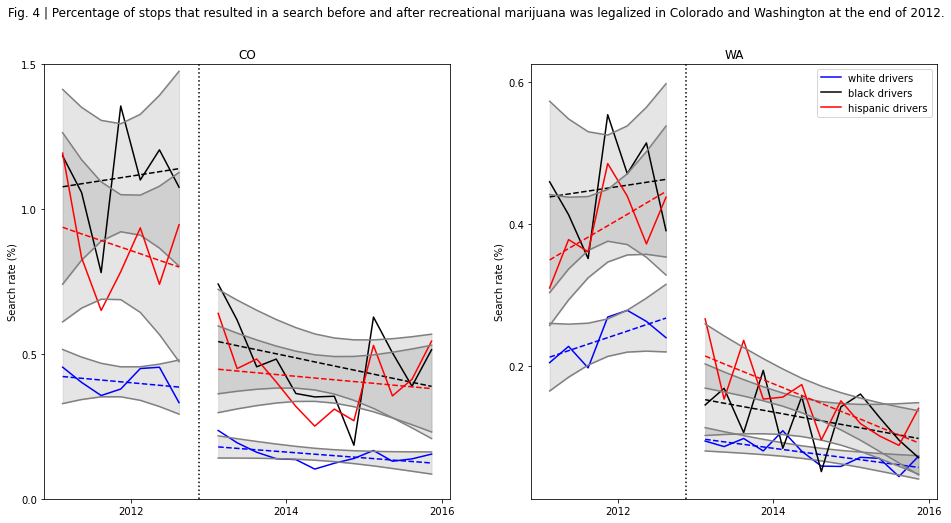

In [164]:
#produce two subplots
fig, axs = plt.subplots(1, 2, figsize=(16,8))
plt.suptitle('Fig. 4 | Percentage of stops that resulted in a search before and after recreational marijuana was legalized in Colorado and Washington at the end of 2012.')

#fill plots up with loop 
for n, state in enumerate(states_of_interest):
    # Cookie points:Set the exact same years as in the paper for the x axis (helps us to compare)
    axs[n].set_xticks([pd.to_datetime('2012-01-01'), pd.to_datetime('2014-01-01'), pd.to_datetime('2016-01-01')])
    # Set title, axis, legalization date 
    axs[n].title.set_text(state) 
    axs[n].set_ylabel('Search rate (%)')
    l1 = axs[n].axvline(x=pd.to_datetime('2012-11-15'),c='k', ls=':') 
    for period in df.pre_legalization.unique():
        #Add only one legend
        if  bool(period) & n==1:
                axs[n].legend(loc="upper right")
                
        for race in df.driver_race.unique():
            #Define line colors for skinn colors (same as in paper)
            if race == 'white': set_color = 'blue'
            elif race == 'black': set_color = 'black'
            elif race == 'hispanic': set_color = 'red'
            
            #Filter df for the relevant, specified info: state, race, pre post leaglization
            relevant_df = df[(df['state']==state) & (df['driver_race']==race) & (df['pre_legalization']==period)]
            quarters = relevant_df.quarter
            search_rates = relevant_df.search_rate*100
            #Plot the data
            state_plot = axs[n].plot(quarters, search_rates, label=race + ' drivers', color = set_color)
            
            #Get linear trend, upper and lower confidence intervals 
            ypred, upper, lower = linear_trend_ci(quarters, search_rates)
            
            #Plot linear trend, confidence intervals and color the region between the confidence intervals gray
            lineartrend = axs[n].plot(quarters, ypred, linestyle='--', color = set_color)
            conf_inter_plot = axs[n].plot(quarters, upper, color = 'grey')
            onf_inter_plot = axs[n].plot(quarters, lower, color = 'grey')
            axs[n].fill_between(quarters, lower, upper, color='grey', alpha=0.2)

            
#Cookie points: Set the exact same axis ticks as in original paper
axs[0].set_ylim([0,1.5])
axs[0].yaxis.set_major_locator(plt.MaxNLocator(3))
axs[1].yaxis.set_major_locator(plt.MaxNLocator(4))



## 3) Discussion  & Compare to Paper
**Plotted search rates:** The plottted search race per race and period seem to be an exact reproduction of the original paper. Comparing such features as maximas, lines which cross and begining and end points of the plots, I come to the conclusion that this is an exact reproduction.   
**Linear trends & Confidence intervals:** My linear trends and confidence intervals seem not to match with the paper. In some cases the slope doen't match, in a few cases even indicating a different trend then in the original paper.   
How can this be explained: 1) either they use a different model then I do or 2) they use different inputs. 1) I tried to investigate this question by looking at their repository (of the paper). They created this plot in the R programing language with ggplot2 and the linear model 'lm', which correspondents to a linear regression. Therefore I guess they use the same model then I do. 2) It could be that they use different input variables, namely that they weight there quarterly search rate by the number of searchs in this quarter. This could explain the divergence in linear trends of the reproduction and original. However, I can not fully prove this because their R code is very confusing and I do not full understand which input variables they take for their linear trend.   
Best guess --> They weight their linear trends by the number of search rates per quarter.   
  
**Conclusion:** Can I perfectly reproduce their results? No. Does this invalidate their argumentation and the conclusion they draw? No   
I can still argue that search rates pre legalization were higher and that there seem to be significant differences in search rates between minorities and whites pre and post legalization.   
Thus their general argument which they make with this plot still holds

